In [1]:
import re
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.corpus import words
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
from nltk.tokenize import RegexpTokenizer
from nltk.stem.lancaster import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /Users/barry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/barry/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /Users/barry/nltk_data...
[nltk_data]   Package words is already up-to-date!


# Keywords

Here we define a collection of keywords to use as corpus to have the information retrieval model to pay attention to. TF-IDF was chosen as the IR model for filtering the keywords as it can rank the importance of the words based on how informative the term is. For example, a rare term such as 'lagrange duality' carries more information about a course than 'data science', with TF-IDF, this level of information can be captured; whereas term frequency based model would only return the keywords that have the most number of appearance throughout, resulting in broad terms such as 'management' and 'data science', which are not as informative.

The process begun with text cleaning, which includes removing stopwords and words with specific tense. This reduces the number of words to process, and it also ensures that the text is left only keywords and other words that were not able to clean. Ideally, lemmetization and stemming would also be applied to group words with the same stem together. It was not applied due to the over simplification of keywords. For example, stemming or lemmetizing 'data science' would result in 'dat sci,' which is not easy to interpret by human.

The corpus used for different topics are also tuned to have keywords that relate only to that topic. as it is not useful to look for 'Model Boosting' in a risk management course. The number of features used for TF-IDF was tuned manually by trials of error, it was found out that at 500 features, the model was able to return reasonable keywords. Constraints were added to make sure that the keywords returned definately appears in the keyword dictionary, for each course, the top 10 most important keywords based on TF-IDF term informative-ness ranking were returned for analysis.

After text being cleaned and model being setup, the keywords from every course description were processed, which would help in analyzing which data science or business analysis topics are the most popular ones amongst all of the courses on Courera. Then, based on that topic, we can then extract courses with these topics as keywords to find what other specific toopics that may be taught as sections for this topic. More details of this procedure are introduced respectively in their sections.

In [2]:
skills_keywords_dict = {
        # tech skills
        'Excel': ['Excel'],
        'Python': ['Python'],
        'R': ['R ', ' R ', 'R,', 'R/'], # 'R' surrounded by spaces and signs
        'Java': ['Java', 'JVM'],
        'Scala': ['Scala'],
        'C/C++': ['C/C++', 'C++', ' C '],   # 'C' surrounded by spaces and signs
        'MATLAB': ['MATLAB'],
        'SAS': ['SAS'],
        'Web Dev': ['CSS', 'HTML'],
        'SQL/databases': ['SQL', 'databases'],
        'Oracle':['Oracle'],
        'SPSS': ['SPSS'],
        'Stata': ['Stata'],
        'Machine Learning': ['Machine Learning', 'ML', 'AI', 'Artificial Intellegence'],
        'Data Mining/Analytics': ['Data Mining', 'DM', 'Analytics', 'Data Science', 'Data Analytics'],
        'NLP': ['Natural Language Processing', 'NLP'],
        'Visualisation': ['Visualisation', 'Visualization'],
        'Big Data': ['Big Data', 'Spark', 'kafka', 'Hive','beam', 'Hadoop', 'MapReduce', 'Hbase','Cloudera', 'Hortonworks'],
        'AWS Cloud': ['AWS'],
        'Probability': ['probablity', 'probability theory', 'probablistic model'],
        'Support Vector Machines': ['SVM', 'Support vector machines'],
        'Neural Networks': ['Neural Networks', 'ANN', 'MLP', 'CNN', 'Tensorflow', 'Keras', 'Theano'],
        'GCP': ['GCP'],
        'Jason': ['Jason'],
        'xml': ['xml'],
        'Azure': ['Azure'],
        'Google Cloud': ['Google Cloud'],
        'Mathematics': ['Mathematics'],
        'IBM': ['IBM'],
        'Algebra': ['Algebra'],
        'Statistics' :  ['Statistics'],
        'Operations research': ['Operations research'],
        'DevOps': ['DevOps', 'TDD', 'test-driven'],
        'Git':['GitHub', 'Git', 'version control'],
        # soft skills
        'presentation' : ['communication', 'presentation'],
        'management' : ['management', 'Data management'],
        'agile' : ['agile'],
        'SDLC' : ['SDLC', 'sdlc', 'software development', 'lifecycle'],
        'decision making' : ['decision making', 'decision analysis'],
        'problem solving': ['problem solving'],
        'Team building': ['Team leadership', 'team building'],
        'project_management': ['project management'],
        'leadership': ['leadership'],
        'consulting': ['consulting', 'consultant']}

topic_keywords_dict = {
    'linear algebra': ['matrix multiplication', 'identity matrix', 'diagonal matrix', 'transpose', 
                       'symmetric matrix', 'trace', 'norms', 'linear dependency', 'rank', 'inverse',
                       'orthogonal matrix', 'nullspace', 'columnspace', 'rowspace', 'determinant',
                       'positive semidefinite', 'eigenvalues', 'eigenvectors', 'SVD', 'matrix calculus'],
      
    'statistics': ['counting', 'permutation', 'combination', 'conditional probability', 'independence',
                   'random variables', 'expectation', 'bernoulli', 'binomial', 'poisson', 'normal', 
                   'joint distribution', 'marginal distribution', 'covariance', 'beta distribution',
                  'sampling', 'bootstrapping', 'inference', 'MLE', 'bayes', 'posterior'],
      
    'MATLAB': ['surface plot', 'line plot', 'linear algebra', 'polynomial','solve equations', 'differentiation', 
               'integration', 'differential equation', 'data structure'],
      
    'python': ['function', 'flow control', 'class', 'numpy', 'pandas', 'scikit learn', 'visualization', 
               'matplotlib', 'pytorch', 'scraping','tendorflow'],
    
    'machine learning': ['linear regression', 'logistic regression', 'generative learning', 'SVM', 'KNN', 
                         'decision tree', 'softmax', 'ensemble', 'neural network', 'convolutional neural network',
                         'recurrent neural network', 'pca', 'k means', 'expectation maximization', 
                         'reinforcement learning', 'deep learning'],
    
    'cloud computing':['clouds, MapReduce', 'key-value','NoSQL', 'classical distributed algorithms', 
                       'widely-used distributed algorithms', 'scalability', 'trending areas', 'C++',
                      'Docker', 'JVM','Kubernates','AWS','Amazon','RPC','JSON','Big data','deep learning','spark'],
    
    'data mining':['structured','unstructured','natural language','information retrieval','IR','serach engine',
                   'query','patterns','cluster','clustring','text','recommendation'],
    
      
    'java': ['flow control', 'OOP', 'array', 'list', 'class','JVM', 'constructor', 'exception', 
             'collection', 'web development', 'cloud', 'web application', 'web stadards', 'web container', 
             'client', 'http', 'deployment descriptor'],

    'scala': ['defination', 'function', 'scope', 'recursion', 'structure information', 'list', 'string',
              'tuples', 'objects', 'class','web application', 'data streaming', 'batch processing', 
              'distributed', 'spark', 'AWS', 'Ad hoc'],
    
    'sql': ['join table', 'select', 'join table', 'group', 'subquery', 'modify table', 'constraints',
            'trigger', 'view', 'function', 'programming', 'relational', 'database', 'groupby','data types'],
      
    'big data': ['sql','descriptive analytics', 'predictive analytics','prescriptive analytics', 
                 'batch processing','cassandra', 'cloud computing', 'cluster computing', 'data lake', 
                 'data mining', 'distributed file-system', 'ETL','Hadoop','in memory', 'IoT','machine learning',
                 'mapReduce', 'NoSQL','Spark','stream Processing', 'structered data', 'unstructured data'],

    'nlp': ['regular expression', 'n-gram', 'neural language model', 'glove', 'embedding', 'attention', 
            'transformer', 'sentiment','information retrieval', 'tokenization','query','parsing',
            'segmentation', 'stemming', 'lemmatization','speech rocognization'],
    
    'ai':['speech recognition','computer vision','decision theory'],

    'decision theory' : ['mathematics','game trees','stochastic','repeated','prisoner','Nash','equilibrium',
                         'dominant','backward induction','game theory','utility function','maximize likelihood',
                         'decision tree','influence diagram','continuous probability','discrete probability',
                         'probability distribution','beta distribution','gamma distribution','binomial distribution',
                         'poisson distribution','conjugate prior','influence diagram','baysian network'],

    'computer vision' : ['machine vision','vision system','video system','sighting system','vision system',
                         'motion','perception','slam','camera pose','hardware','CPU','GPU','microcomputer',
                         'microprocessor','image processing','object recognition','image filter','object detection',
                         'LSTM'],

    'network': ["communication", "web", "services", "html", "cloud", "devices", "TCP", "IP", "OSI", "address", 
                "routing", "protocol", "DHCP", "ethernet", "wireless", "WAN", "LAN"],

    'speech recognition' :["signal processing", "acoustic", "linguistic", "decoding", "deep learning","audio", 
                           "sequence data", "GRU", "wave", "decode", "speaker", "vocabulary", "corpora", 
                           "Gaussian mixture", "probabilistic", "pattern", "language", "profanity", "diarization", 
                           "parity"]}


ba_keywords = {
    'business analysis' : ['business development','sales','product management','business process',
                           'business intelligence','presales','sql','consultant','business consulting','oracle',
                           'strategy','finance','erp','business analytics','market research','product development',
                           'sales strategy'],

    'management' : ['project management','consultant','analyst','enterprise risk management','auditing',
                    'revenue assurance','client management','account management','business process','sox',
                    'regional sales','change management','team management'],

    'project management': ["project","schedule","resource allocation","management","budget","gantt chart",
                           "work breakdown structure","scope","quality","vitruvius","cost engineering","risk",
                           "project team","operations research","business operations","projects","resource",
                           "scientific management","critical path","program evaluation", "review technique"],
    
    'risk' : ['hedge','risk','finance','variance','financial trasaction','downside risk','financial risk management',
              'diversification','modern portfolio','acutary','bond','exposure','gamble','gedge','secure',
              'entrepreneur','standard deviation','stake'],

    'data warehouse' : ['schema','operational data store','extract','transform','metadata','data structure',
                        'database','normalization','directory'],
    
    'marketing':['marketing','consumer','uncertainty','market segments','product','positioning','elasticity','brand',
                'advertising','targeting','recommendation'],
    
    'predictive modelling':['predictive','predictive modelling','linear','regression','classification','decision','forecasting'],

    'consultant' : ['sap', 'java','sap fico','sap abap','finance','sap basis','sap mm','sap sd','marketing','design'],
    
    'change':['communication','change','entrepreneur','innovation','flexibility',]}
    
    
#     'BA Tech Skill' :["Operational", "data warehouse", "Analytical", "Microsoft Access", "Software", "Decision-Making",
#                       "SQL", "Intelligence","Resource Allocation", "Analyze", "Key Performance Indicators", 
#                       "Reporting Requirements", "Streamlining", "Business Requirements", "Variance Analysis", 
#                       "Financial Planning", "Business Intelligence", "Big Picture Thinking", "Data Quality", 
#                       "Relationship Building", "Secondary Market", "Scope", "Database", "Workflow", "Milestones", 
#                       "Gathering Information", "Progress Reports", "Technical Reports", "Summarizing Information",
#                       "Business Planning", "Inventory Distribution", "Inquisitive", "Operational Issues", 
#                       "Software Design", "Design Analysis", "Process Improvement", "Business Systems", "Planning", 
#                       "Research", "Communication", "Strategic Planning", "Teamwork", "Communication Skills"]}

## 2.3 Functions

In [4]:
def courseExtract(topics, df):
    course_ID = []
    for topic in topics:
        for keyword_list_num in range(len(df['keywords'])):
            try:
                if topic in df['keywords'][keyword_list_num]:
                    course_ID.append(keyword_list_num)
            except:
                pass
    return list(pd.unique(course_ID))


def organizeKeywords(df_keywords, duplicate = False):
    key_ = []
    for keyword_list in df_keywords:
        key_ += list(keyword_list)
        
        if duplicate == False:
            key_ = list(pd.unique(key_))
    return key_


def cleanSTR(df):
    """
    Cleans out special characters, URL, HTML from
    each post and replace NaN with empty string 
    """
    # Prevent unwanted changes to the original copy
    copy = df.copy()
    # Fill empty NaN/Null
    copy = copy.fillna('')
    cleaned_ = []
    # Both dataset shares 'text'
    for stuff in copy:
        # Unify all characters to lowercase
        stuff = stuff.lower()
        # Remove Stopwords
        # stemmer = LancasterStemmer()
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(stuff)
        # print(tokens)
        stuff = [word for word in tokens if word not in stopwords.words('english')]
        # stuff = [stemmer.stem(word) for word in stuff]
        stuff = [word for word in stuff if word.isdigit() == False]
        # some words such as 'within' almost never appear in keywords, they are filtered.
        tag = nltk.pos_tag(stuff)
        stuff = [tup[0] for tup in tag if tup[1] not in ['IN','JJ','VBD','VBP','JJS','RB','VBG','VBZ']]
        stuff = ' '.join(stuff)
        cleaned_.append(stuff)   
    return cleaned_


def K_Keywords(original_df ,Q_list, corpus, K = 10, keyword_dict = None):
    '''
    PARAMS:\n
    original_df: your original course dataframe\n
    Q_list: list of queries(strings)\n
    corpus: the portion of data you want to use as the database (can be a list of lists)\n
    K: how many keywords to be returned for each course/chapter\n
    keyword_dict: additional keywords you would like to add to the corpus (dictionary: {topic:words})\n
    OUTPUT:\n
    your original dataframe with one extra column of keywords for each course/chapter
    '''
    tfidf = TfidfVectorizer(max_df=0.8, max_features=500, ngram_range=(1,2))
    # Is additional keywords to be used? 
    if keyword_dict:
        extra_words = []
        for (key,item) in keyword_dict.items():
            extra_words += item
        extra_words = [word.lower() for word in extra_words]
    else:
        extra_words = []
    # Set up corpus
    all_corpus = []
    for sub_corpus_list in corpus:
        all_corpus += list(pd.unique(sub_corpus_list))
    all_corpus += extra_words
    print("---Corpus Built---")
    # Initialize TFIDF matrix based on Corpus
    corpus_fit = tfidf.fit_transform(all_corpus)
    print("---Corpus Fited via TFIDF---")
    keywords = []
    for row_num in range(len(Q_list)):
        response = tfidf.transform([Q_list[row_num]])
        words = tfidf.get_feature_names()
        # using the top 10 keywords as the course's tag
        feature_array = np.array(tfidf.get_feature_names())
        tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
        top_n = feature_array[tfidf_sorting][:50]
        kept_word = [word for word in top_n if word in Q_list[row_num]]
        keywords.append(kept_word[:K])
    original_df['keywords'] = keywords

    return original_df


def topic_tokenize(df_section, df_chapter):
    ps = PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')
    s_gram_input = []
    bi_gram_input = []
    for index, row in df_section.iterrows():
        section_token = ''
        section_token += str(row['Section Names']).lower()
        section_token += ' '
        section_token += str(row['Section Descriptions']).lower()
        section_token = tokenizer.tokenize(section_token)
        stuff = [word for word in section_token if word not in stopwords.words('english')]
        s_ = [ps.stem(word) for word in stuff]
        bi_ = nltk.bigrams(s_)
        s_gram_input += s_
        bi_gram_input += bi_
    return s_gram_input, bi_gram_input


def target_tokenize(s_gram, bi_gram):
    ps = PorterStemmer()
    s_target = [ps.stem(word) for word in s_gram]

    bi_target = []
    for i in range(len(bi_gram)):
        word = bi_gram[i]
        first, second = word.split(' ')
        first, second = first.lower(), second.lower()
        first, second = ps.stem(first), ps.stem(second)
        bi_target.append((first, second))
    return s_target, bi_target


def topic_count(s_input, bi_input, s_target, bi_target):
    s_count = {}
    bi_count = {}
    s_count = {i: s_input.count(i) for i in s_target}
    bi_count = {i: bi_input.count(i) for i in bi_target}
    return s_count, bi_count

## 2.4 Courses Design

### 2.4.1 Data Science Courses

##### 1. Introduction to Data Science

This course will help students not only review the knowledge in linear algebra and statistics but also gain a basic knowledge of concepts in data science area. The first half of the semester will cover the basic topics covered in linear algebra and statistics such as determinant, inverse matrix, matrix calculus, expectation, random variable, sampling, inferance and distributions. The second half of the semester students will learn the most popular programming language in data science area - Python, they will implement codes into Jupyter Notebook and get hands on some important libraries such as pandas, numpy and matplotlib in the weekly labs. After this course, students are expected to do some basic data pre-processing on a dataset such as cleaning, joining and merging.

- Linear algebra

In [5]:
la_section = pd.read_csv('section_topics_la.csv', index_col=0)
la_chapter = pd.read_csv('chapter_topics_la.csv', index_col=0)

In [6]:
la_si = ['trace', 'norm', 'rank', 'inverse', 'nullspace', 'determinant', 'semidefinite', 'eigenvalues',
         'eigenvectors', 'SVD', 'orthogonal', 'calculus']

la_bi = ['matrix multiplication', 'identity matrix', 'diagonal matrix', 'symmetric matrix', 'linear dependency']

la_s_target, la_bi_target = target_tokenize(la_si, la_bi)
la_s_input, la_bi_input = topic_tokenize(la_section, la_chapter)
la_s_count, la_bi_count = topic_count(la_s_input, la_bi_input, la_s_target, la_bi_target)

In [7]:
la_s_count

{'trace': 0,
 'norm': 0,
 'rank': 3,
 'invers': 8,
 'nullspac': 0,
 'determin': 20,
 'semidefinit': 0,
 'eigenvalu': 2,
 'eigenvector': 3,
 'svd': 0,
 'orthogon': 3,
 'calculu': 11}

In [8]:
la_bi_count

{('matrix', 'multipl'): 1,
 ('ident', 'matrix'): 0,
 ('diagon', 'matrix'): 0,
 ('symmetr', 'matrix'): 0,
 ('linear', 'depend'): 0}

- Statistics

In [9]:
stats_section = pd.read_csv('section_topics_stats.csv', index_col=0)
stats_chapter = pd.read_csv('chapter_topics_stats.csv', index_col=0)

In [10]:
stats_si = ['counting', 'permutation', 'combination','independence','expectation', 'bernoulli', 'binomial', 'poisson', 'normal',
            'covariance','sampling', 'bootstrapping', 'inference', 'MLE', 'bayes', 'posterior']

stats_bi = ['conditional probability','random variables','joint distribution', 'marginal distribution','beta distribution']

stats_s_target, stats_bi_target = target_tokenize(stats_si, stats_bi)
stats_s_input, stats_bi_input = topic_tokenize(stats_section, stats_chapter)
stats_s_count, stats_bi_count = topic_count(stats_s_input, stats_bi_input, stats_s_target, stats_bi_target)

In [11]:
stats_s_count

{'count': 4,
 'permut': 5,
 'combin': 20,
 'independ': 22,
 'expect': 40,
 'bernoulli': 2,
 'binomi': 7,
 'poisson': 7,
 'normal': 16,
 'covari': 3,
 'sampl': 63,
 'bootstrap': 5,
 'infer': 38,
 'mle': 1,
 'bay': 7,
 'posterior': 2}

In [12]:
stats_bi_count

{('condit', 'probabl'): 11,
 ('random', 'variabl'): 40,
 ('joint', 'distribut'): 2,
 ('margin', 'distribut'): 0,
 ('beta', 'distribut'): 0}

- Python

In [13]:
py_section = pd.read_csv('section_topics_python.csv', index_col=0)
py_chapter = pd.read_csv('chapter_topics_python.csv', index_col=0)

In [14]:
py_si = ['function', 'class', 'numpy', 'pandas', 'visualization','matplotlib', 'pytorch', 'scraping']

py_bi = ['flow control','scikit learn','jupyter notebook']

py_s_target, py_bi_target = target_tokenize(py_si, py_bi)
py_s_input, py_bi_input = topic_tokenize(py_section, py_chapter)
py_s_count, py_bi_count = topic_count(py_s_input, py_bi_input, py_s_target, py_bi_target)

In [15]:
py_s_count

{'function': 45,
 'class': 18,
 'numpi': 1,
 'panda': 4,
 'visual': 38,
 'matplotlib': 15,
 'pytorch': 2,
 'scrape': 4}

In [16]:
py_bi_count

{('flow', 'control'): 0, ('scikit', 'learn'): 1, ('jupyt', 'notebook'): 16}

##### 2. Relational Databases

The purpose of this course is to introduce the concepts of both relational and unrelational databases and introduce tools that can extract data from them. The main focus will be on the RDBMS and let students gain knowledge of the SQL language. The emphasis in this course is on hands-on and practical learning, students will work with real databases, real data science tools, and real-world datasets bu using clusters or cloud technology. After this course, students are expected to have skills to write SQL language such as 'select', 'join', 'group' and other sub-query commands.

In [17]:
sql_section = pd.read_csv('section_topics_sql.csv', index_col=0)
sql_chapter = pd.read_csv('chapter_topics_sql.csv', index_col=0)

In [18]:
sql_si = [ 'select', 'join table', 'group', 'subquery', 'constraints','trigger', 'view', 'function', 'programming']

sql_bi = ['join table','modify table']

sql_s_target, sql_bi_target = target_tokenize(sql_si, sql_bi)
sql_s_input, sql_bi_input = topic_tokenize(sql_section, sql_chapter)
sql_s_count, sql_bi_count = topic_count(sql_s_input, sql_bi_input, sql_s_target, sql_bi_target)

In [19]:
sql_s_count

{'select': 21,
 'join tabl': 0,
 'group': 22,
 'subqueri': 4,
 'constraint': 4,
 'trigger': 0,
 'view': 20,
 'function': 79,
 'program': 158}

In [20]:
sql_bi_count

{('join', 'tabl'): 2, ('modifi', 'tabl'): 0}

##### 3. Introduction to Natrual Language Processing

This course will cover most of the important topics in natural language processing area. Students are starting with  learning how to use regular expressions in python to search for custom patterns inside of text files, and using certain libraries like NLTK to understand fundamental NLP concepts such as stemming, lemmatization, stop words, phrase matching, tokenizations...etc. Then students are expected to retrive data by queries in a corpus and use machine learning with Scikit-Learn to conduct text classification such as spam-detection. At the end of this course, students are required to do a project related to sentiment analysis of text with the NLTK library, and creating semantic word vectors with the Word2Vec algorithm.

In [21]:
nlp_section = pd.read_csv('section_topics_nlp.csv', index_col=0)
nlp_chapter = pd.read_csv('chapter_topics_nlp.csv', index_col=0)

In [22]:
nlp_si = ['n-gram', 'glove', 'embedding', 'attention', 'transformer', 'sentiment','tokenization','query','parsing','segmentation', 'stemming', 'lemmatization']

nlp_bi = ['regular expression','neural-language model','information retrieval','speech rocognization']

nlp_s_target, nlp_bi_target = target_tokenize(nlp_si, nlp_bi)
nlp_s_input, nlp_bi_input = topic_tokenize(nlp_section, nlp_chapter)
nlp_s_count, nlp_bi_count = topic_count(nlp_s_input, nlp_bi_input, nlp_s_target, nlp_bi_target)

In [23]:
nlp_s_count

{'n-gram': 0,
 'glove': 1,
 'embed': 8,
 'attent': 3,
 'transform': 11,
 'sentiment': 9,
 'token': 7,
 'queri': 37,
 'pars': 2,
 'segment': 1,
 'stem': 0,
 'lemmat': 0}

In [24]:
nlp_bi_count

{('regular', 'express'): 6,
 ('neural-languag', 'model'): 0,
 ('inform', 'retriev'): 3,
 ('speech', 'rocogn'): 0}

##### 4. Big Data Science

You will gain an understanding of what insights big data and will be guided through some basic tools used in the big data environemnt such as extracting data from database by SQL, using Hadoop with MapReduce, Spark, Pig and Hive. Students will perform predictive modeling by machine learning and visual graph analytics to model problems in a final project, developed in partnership with data company such as TD and IBM, students are expected to apply the skills they learned to do basic analyses of big data and give presentation to partners. In this course, there is no requirements for Python programming language and students are going to use clusters and Cloud platform to analyse data using new programming languages PySpark and Scala.

- Bigdata

In [25]:
bd_section = pd.read_csv('section_topic_bigdata.csv', index_col=0)
bd_chapter = pd.read_csv('chapter_topics_bigdata.csv', index_col=0)

In [26]:
bd_si = ['sql','cassandra', 'ETL','Hadoop', 'IoT','mapReduce', 'NoSQL','Spark',]

bd_bi = ['descriptive analytics', 'predictive analytics','prescriptive analytics', 'batch processing', 'cloud computing', 'cluster computing', 'data lake', 'data mining', 
         'distributed file-system','in memory','machine learning','stream Processing', 'structered data', 'unstructured data' ]

bd_s_target, bd_bi_target = target_tokenize(bd_si, bd_bi)
bd_s_input, bd_bi_input = topic_tokenize(bd_section, bd_chapter)
bd_s_count, bd_bi_count = topic_count(bd_s_input, bd_bi_input, bd_s_target, bd_bi_target)

In [27]:
bd_s_count

{'sql': 67,
 'cassandra': 1,
 'etl': 4,
 'hadoop': 21,
 'iot': 24,
 'mapreduc': 8,
 'nosql': 11,
 'spark': 52}

In [28]:
bd_bi_count

{('descript', 'analyt'): 1,
 ('predict', 'analyt'): 15,
 ('prescript', 'analyt'): 4,
 ('batch', 'process'): 0,
 ('cloud', 'comput'): 14,
 ('cluster', 'comput'): 0,
 ('data', 'lake'): 7,
 ('data', 'mine'): 2,
 ('distribut', 'file-system'): 0,
 ('in', 'memori'): 0,
 ('machin', 'learn'): 51,
 ('stream', 'process'): 2,
 ('structer', 'data'): 0,
 ('unstructur', 'data'): 3}

- Scala

In [29]:
scala_section = pd.read_csv('section_topics_scala.csv', index_col=0)
scala_chapter = pd.read_csv('chapter_topics_scala.csv', index_col=0)

In [30]:
scala_si = ['definition', 'function', 'scope', 'recursion', 'list', 'string','tuples', 'objects',
            'class', 'distributed', 'spark', 'AWS', 'Ad hoc']

scala_bi = ['structure information', 'web application', 'data streaming', 'batch processing']

scala_s_target, scala_bi_target = target_tokenize(scala_si, scala_bi)
scala_s_input, scala_bi_input = topic_tokenize(scala_section, scala_chapter)
scala_s_count, scala_bi_count = topic_count(scala_s_input, scala_bi_input, scala_s_target, scala_bi_target)

In [31]:
scala_s_count

{'definit': 7,
 'function': 70,
 'scope': 1,
 'recurs': 2,
 'list': 12,
 'string': 2,
 'tupl': 0,
 'object': 38,
 'class': 11,
 'distribut': 29,
 'spark': 42,
 'aw': 4,
 'ad hoc': 0}

In [32]:
scala_bi_count

{('structur', 'inform'): 0,
 ('web', 'applic'): 10,
 ('data', 'stream'): 3,
 ('batch', 'process'): 0}

##### 5. R Programming in Data Science

This course introduces how to program in R and how to use R programming for data analysis. In the half of the semester, this course will cover basic programming skills in which includes reading data into R, importing R packages, writing R functions and debugging. In the second half of the semester, students will be introduced to statistical data analysis which includes cleaning data and doing exploraroty data analysis and reproducible research, and in the final project, students are required to implement regression models from machine learning to predict the results from a real dataset. Pre-knowledge in machine learning is recommended but not necessarily required.

In [33]:
r_section = pd.read_csv('section_topics_R.csv', index_col=0)
r_chapter = pd.read_csv('chapter_topics_R.csv', index_col=0)

In [34]:
r_si = ['statistics', 'environment','packages','simulation','analysis','cleaning','explore','regression','prediction']

r_bi = ['exploratory data','reproducible research','machine learning','statistical inference','regression model']

r_s_target, r_bi_target = target_tokenize(r_si, r_bi)
r_s_input, r_bi_input = topic_tokenize(r_section, r_chapter)
r_s_count, r_bi_count = topic_count(r_s_input, r_bi_input, r_s_target, r_bi_target)

In [35]:
r_s_count

{'statist': 32,
 'environ': 22,
 'packag': 18,
 'simul': 11,
 'analysi': 85,
 'clean': 8,
 'explor': 73,
 'regress': 76,
 'predict': 23}

In [36]:
r_bi_count

{('exploratori', 'data'): 13,
 ('reproduc', 'research'): 2,
 ('machin', 'learn'): 37,
 ('statist', 'infer'): 0,
 ('regress', 'model'): 18}

##### 6. Excel for Business

This course is desgined to wo kinds of learners - those who have very little functional knowledge of Excel and those who use Excel regularly and wish to enhance their skills. Some basic operations such as reading data into excel using various data formats, organizing and manipulating data, using advanced functions of Excel such as VLOOKUP and Pivot Table and all concepts are taught with easy to understand examples which will help students to learn comfortably. In the final project, students need to use what they have learned into extracting meaningful information from large datasets, presenting data and finally applying advanced formulas and conditional logic to forecast and model data and help make business decisions.

In [37]:
excel_section = pd.read_csv('section_topics_excel.csv', index_col=0)
excel_chapter = pd.read_csv('chapter_topics_excel.csv', index_col=0)

In [38]:
excel_si = ['formatting','functions','arithmetic','reference','VLOOKUP','HLOOKUP','RANDBETWEEN','graphing',
           'histogram','scatter','forecast','model','present','automation']

excel_bi = ['logical condition','data filtering','pivot table','bar chart','pie chart','make decision']

excel_s_target, excel_bi_target = target_tokenize(excel_si, excel_bi)
excel_s_input, excel_bi_input = topic_tokenize(excel_section, excel_chapter)
excel_s_count, excel_bi_count = topic_count(excel_s_input, excel_bi_input, excel_s_target, excel_bi_target)

In [39]:
excel_s_count

{'format': 20,
 'function': 93,
 'arithmet': 0,
 'refer': 16,
 'vlookup': 5,
 'hlookup': 1,
 'randbetween': 0,
 'graph': 7,
 'histogram': 2,
 'scatter': 0,
 'forecast': 37,
 'model': 207,
 'present': 85,
 'autom': 11}

In [40]:
excel_bi_count

{('logic', 'condit'): 1,
 ('data', 'filter'): 2,
 ('pivot', 'tabl'): 11,
 ('bar', 'chart'): 0,
 ('pie', 'chart'): 1,
 ('make', 'decis'): 4}

##### 7. Introduction to Web Development

This course covers the basics os structure of websites and how to write correct HTML5 and CSS3 and create interactive web experiences with JavaScript. Students are expected to develop high quality wesites and publish their webpages for the world to see. Finally, students need to finish a proejct on web applications to let them get the basics of designing web applications - programming useful and dynamic webpages that allow our users to interact with them and develop a working model for creating their own personal websites. Students are recommended to have some pre-knowledge on JavaScript before taking this course.

In [41]:
java_section = pd.read_csv('section_topics_java.csv', index_col=0)
java_chapter = pd.read_csv('chapter_topics_java.csv', index_col=0)

In [42]:
java_si = ['OOP', 'array', 'list', 'class','JVM', 'constructor', 'exception', 'collection', 'cloud', 
              'client', 'http']

java_bi = ['flow control','web development','web application', 'web stadards', 'web container', 'deployment descriptor']

java_s_target, java_bi_target = target_tokenize(java_si, java_bi)
java_s_input, java_bi_input = topic_tokenize(java_section, java_chapter)
java_s_count, java_bi_count = topic_count(java_s_input, java_bi_input, java_s_target, java_bi_target)

In [43]:
java_s_count

{'oop': 0,
 'array': 39,
 'list': 33,
 'class': 60,
 'jvm': 0,
 'constructor': 0,
 'except': 4,
 'collect': 16,
 'cloud': 96,
 'client': 19,
 'http': 7}

In [44]:
java_bi_count

{('flow', 'control'): 0,
 ('web', 'develop'): 0,
 ('web', 'applic'): 12,
 ('web', 'stadard'): 0,
 ('web', 'contain'): 0,
 ('deploy', 'descriptor'): 0}

### 2.4.2 Artificial Intelligence

**Procedure:**

With a comprehensive keywords as corpus, TF-IDF is used to search and rank keywords it has found that is related to each of the courses. These keywords can then be sorted and analyzed to see which topics or skills are the most important based on how many times they have been mentioned in all of the courses we have collected. Then, we can determine the main topics of this particular section of the course based on which part of the Artificial Intellegence is mentioned the most accross all courses that lectured on AI. Due to the fact that this model can extract both high-level and specific topics, the result is mannually processed to pick out the most popular topics as main sections for AI. In this case, we have chosen Machine learning, Computer Vision, and Decision Theory, based on the graph plotted for all keywords.

In [45]:
ai_data = pd.read_csv("section_topics_ai.csv",index_col=0)
ai_data_with_keyword = K_Keywords(original_df = ai_data, 
                    Q_list = cleanSTR(ai_data['Section Descriptions']),
                    corpus = [],
                    keyword_dict = topic_keywords_dict,
                    K=10)

---Corpus Built---
---Corpus Fited via TFIDF---


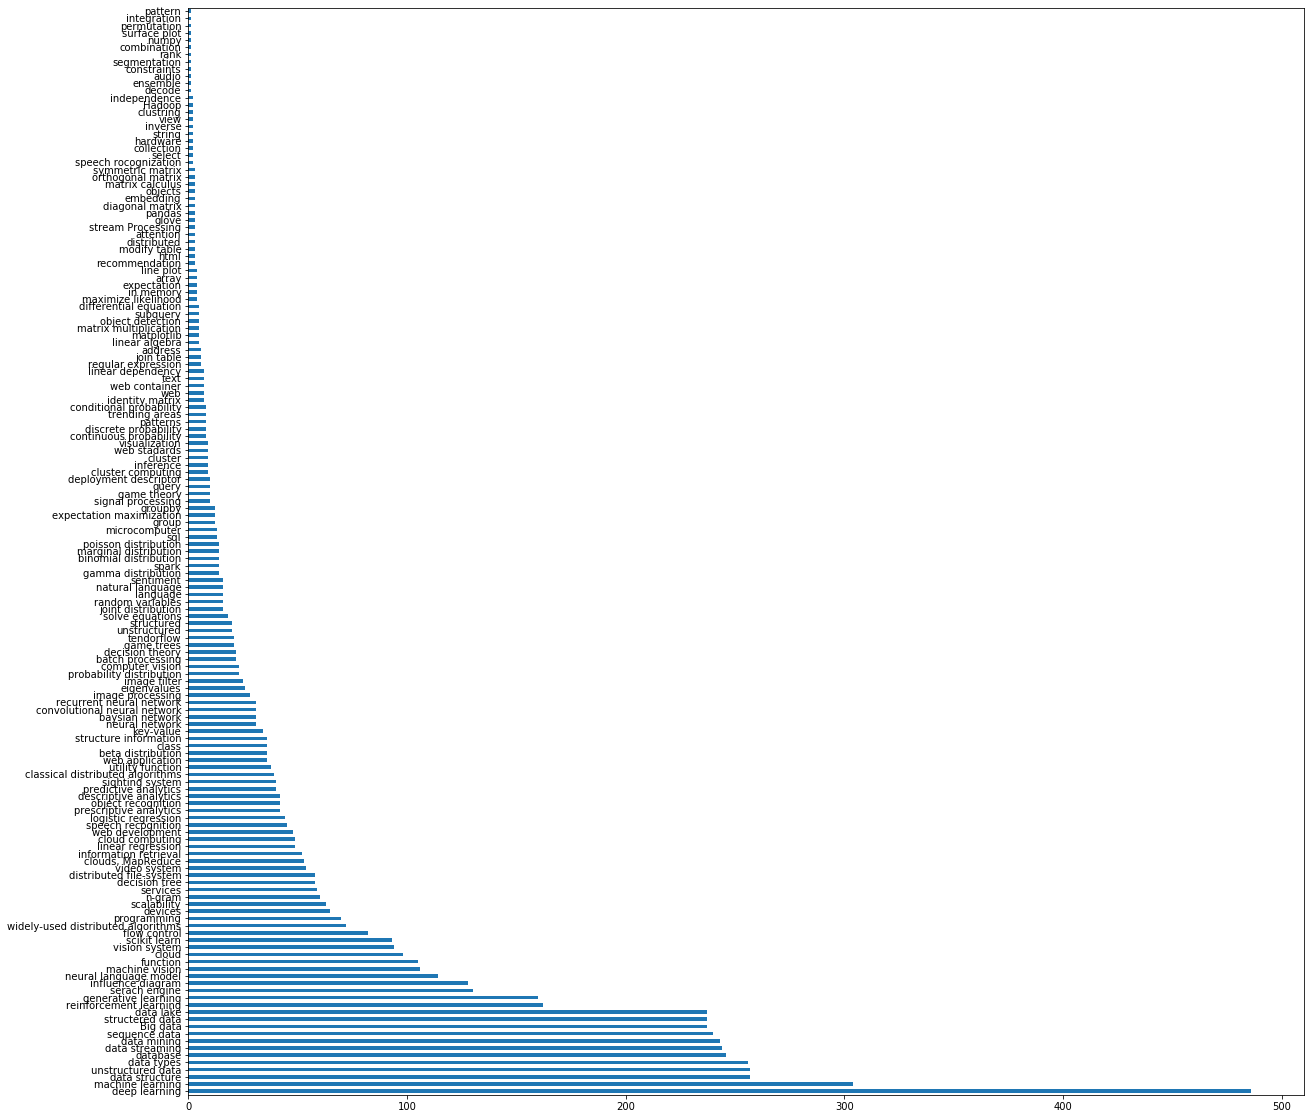

In [46]:
noisy_keys = []
for key_list in ai_data_with_keyword['keywords']:
    noisy_keys += key_list

realKeys = []
for key_list in list(topic_keywords_dict.values()):
    realKeys += key_list

Keys = []
for noisyKey in noisy_keys:
    for realKey in realKeys:
        if noisyKey in realKey:
            Keys.append(realKey)

pd.Series(Keys).value_counts().plot(kind='barh',figsize=(20,20))
plt.show()

##### 8. Applied Machine Learning

Machine learning brings together computer science and statistics to harness that predictive power. It’s a must-have skill for all aspiring data analysts and data scientists, or anyone else who wants to wrestle all that raw data into refined trends and predictions. This course will combine both the knowledge of computer science and statistics to provide you a foundamental understanding of machine learning algorithms and the mathematical proof of them(K Nearest Neighbors, linear regression, logistic regression, decision tree, ensembles, support vactor machine, multilayer perceptrons, convolutional neural networks) as well as demonstrate how these algorithms can help people analyze data in real life. In addition, optimization methods such as gradient descent, back-propagation in neural networks are also included in this course. Tool used in this course include python, tensorflow and pytorch.

**Procedure:**

For machine learning, we searched all keywords for courses that mentioned 'machine learning', to increase the documents returned, the segmented words 'machine' and 'learning' are also searched. This is equivalent to performing a OR search which is a common method in information retrieval for improving the results. All of the keywords returned are then plotted based on their frequency of occurance. The results have shown that, in Artificial Intelligence, 'deep learning','reinforcement learning', and 'generative learning' are the most popular topics within the machine learning compartment.

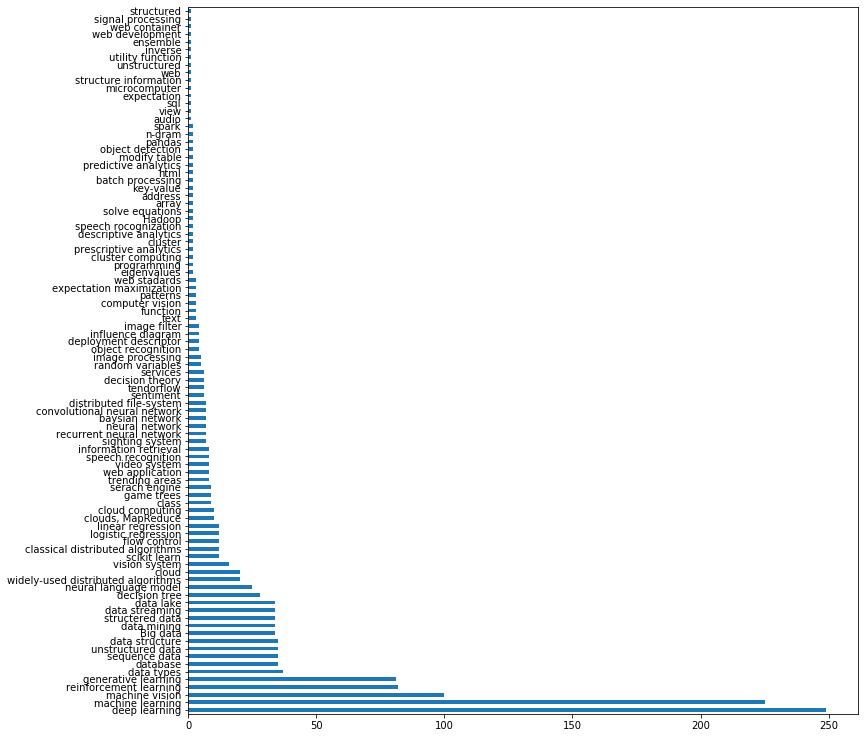

In [47]:
topics = ['machine learning','machine','learning']

keylists = ai_data_with_keyword['keywords'][courseExtract(topics, ai_data_with_keyword)]
L = []
for keylist in keylists:
    L += keylist

real_keys = []
for key_list in list(topic_keywords_dict.values()):
    real_keys += key_list

key = []
for noisyKey in L:
    for realKey in real_keys:
        if noisyKey in realKey:
            key.append(realKey)

pd.Series(key).value_counts().plot(kind='barh',figsize=(12,13))
plt.show()

##### 9. Introduction to Data Mining

This course will introduce the concepts of information retrieval and pattern discovery which are included in text mining areas. Students will learn the basic principles, and the major techniques in information retrieval from search engines by quickly discovering a small part of relevant text data in a large collection. Then students are introduced the methods to discover patterns in the text retrieved by clustering which includes all kinds of unsupervised machine learning method such as K-means, DBSCAN and OPTICS. In the final project, students are expected to do a text mining and pattern discovery on any topic they are interested in to help them improve their knowledge and skills.

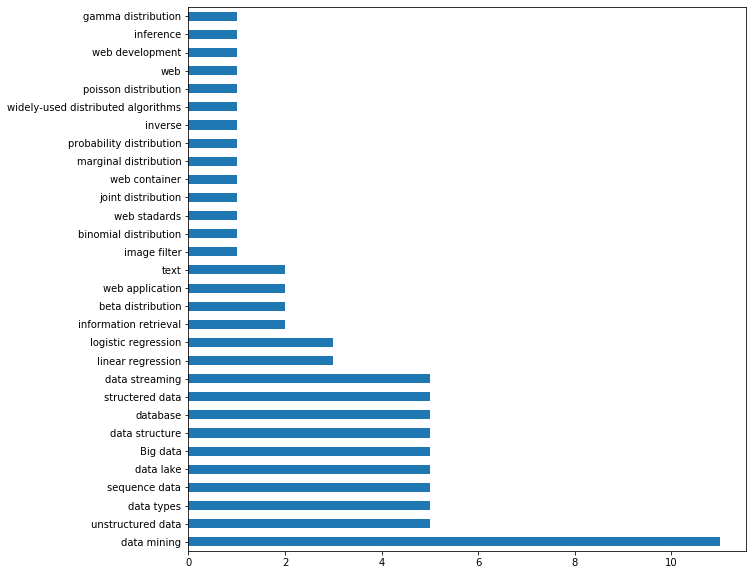

In [48]:
topics = ['data maning','mining']

keylists = ai_data_with_keyword['keywords'][courseExtract(topics, ai_data_with_keyword)]
L = []
for keylist in keylists:
    L += keylist

real_keys = []
for key_list in list(topic_keywords_dict.values()):
    real_keys += key_list

key = []
for noisyKey in L:
    for realKey in real_keys:
        if noisyKey in realKey:
            key.append(realKey)

pd.Series(key).value_counts().plot(kind='barh',figsize=(10,10))
plt.show()

##### 10. Introduction to Cloud Computing in Big Data

This course covers the basic ideas in cloud computing which include the concepts related to clouds, NoSQL databases, distributed file systems by firstly introduces the difficulties in storing and processing large scale of data in a industry level and then, the infrastructure of cloud system are covered by looking at the cloud systems in the big three companies: Amazon, google and Microsoft and comparing them. Finally, students will be introduced to a higher level cloud services with special focus on cloud storage services which includes topics in big data such as MapReduce, Spark, Cloudera and HDFS. The final project in this course will provide students the cloud and big data platform to implement machine learning algorithms on a large scale datasets.

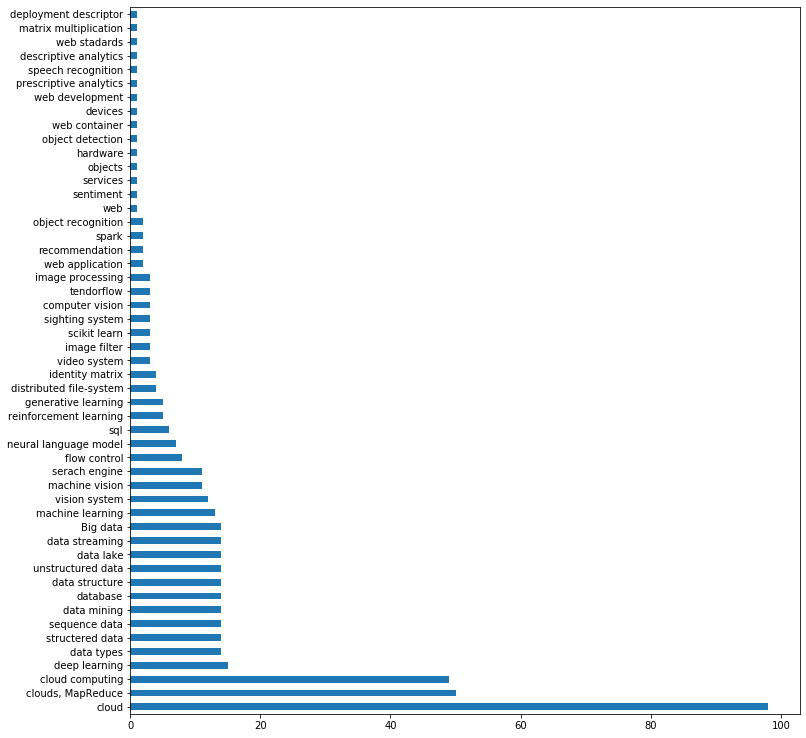

In [49]:
topics = ['cloud','cloud computing']

keylists = ai_data_with_keyword['keywords'][courseExtract(topics, ai_data_with_keyword)]
L = []
for keylist in keylists:
    L += keylist

real_keys = []
for key_list in list(topic_keywords_dict.values()):
    real_keys += key_list

key = []
for noisyKey in L:
    for realKey in real_keys:
        if noisyKey in realKey:
            key.append(realKey)

pd.Series(key).value_counts().plot(kind='barh',figsize=(12,13))
plt.show()

##### 11. Computer Vision

This course provides an introduction to computer vision including fundamentals of image formation, camera imaging geometry, feature detection and matching, multiview geometry including stereo, motion estimation and tracking, and classification. We focus on the machine learning aspect of computer vision, for example: using deep learning algoritms such as convolutional neural network on image data to extract features, detect and recognize objects.

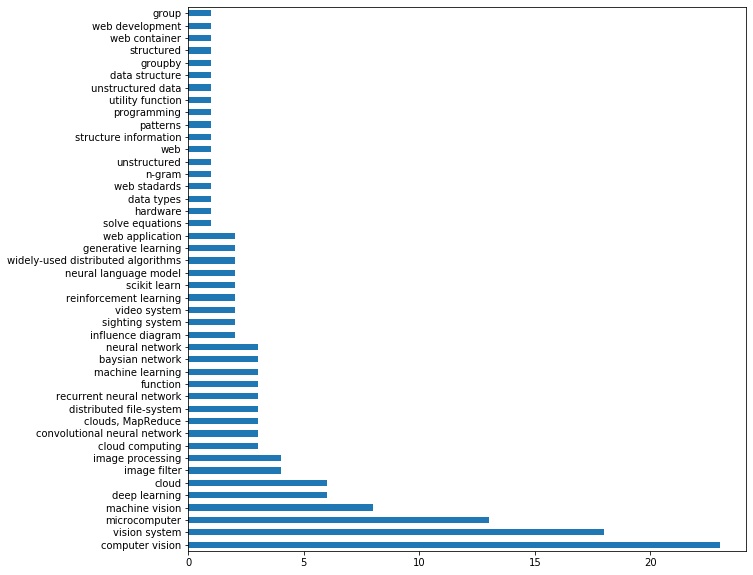

In [50]:
topics = ['computer vision','computer','vision']
keylists = ai_data_with_keyword['keywords'][courseExtract(topics, ai_data_with_keyword)]
L = []
for keylist in keylists:
    L += keylist

real_keys = []
for key_list in list(topic_keywords_dict.values()):
    real_keys += key_list

key = []
for noisyKey in L:
    for realKey in real_keys:
        if noisyKey in realKey:
            key.append(realKey)
pd.Series(key).value_counts().plot(kind='barh',figsize=(10,10))
plt.show()

##### 12. Decision Theory and Game Theory

This course provides a brief introduction to both decision theory and game theory and the different between them. Main focus in this course will be on the game theory which includes game trees, Bayesian models and repeated and stochastic games. Our main goal is to understand the basic ideas behind the key concepts in game theory and use mathematics to solve these problems. We will also see some classic games and applications related to the normal form, payoffs, strategies, pure strategy Nash equilibrium, dominant strategies. 

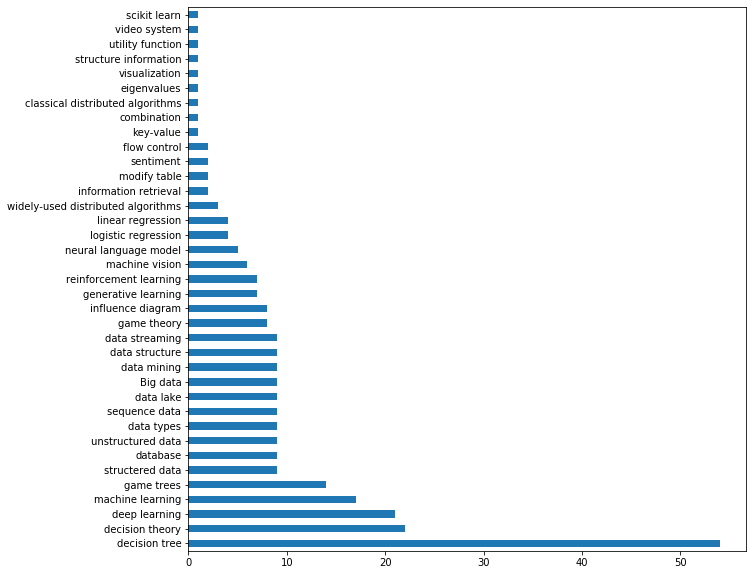

In [51]:
topics = ['decision theory','decision','theory']
keylists = ai_data_with_keyword['keywords'][courseExtract(topics, ai_data_with_keyword)]
L = []
for keylist in keylists:
    L += keylist

real_keys = []
for key_list in list(topic_keywords_dict.values()):
    real_keys += key_list

key = []
for noisyKey in L:
    for realKey in real_keys:
        if noisyKey in realKey:
            key.append(realKey)
pd.Series(key).value_counts().plot(kind='barh',figsize=(10,10))
plt.show()

##### 13. Reinforcement Learning

This course will introduce basic concepts of reinforcement learning anf its relationship with decision-making and AI. Students will learn how an agent works, Markov Decision Process, value functions, exploration and exploitation tradeoff and other basic topics in reinforcement learning. For the rest of this course, students get a basic knowledge on how an agent is learning from its own experience by using methods like Monte Carlo simulation, temporal difference in Q-learnin and also a function approxiamtion method. In the final project, students are expected to complete a reinforcement learning problem in real life which includes  problem formulation, algorithm selection, parameter selection and other components.

### 2.4.3 Business Analytics

**Procedure:**

The general approach for obtaining the course sections and topics for business analysis is very similar as the artificial intelligence section. However, different keyword corpus must be used since it is not likely for a business course to mention topics from computer vision. Therefore, a different set of keywords are fed in to the model, with the results sorted and plotted, we then define the main sections for this part of the lecture: Project management, Risk Management, and Business Intelligence.

In [52]:
ba_data = pd.read_csv('university_courses.csv',index_col=0)
ba_data_with_keyword = K_Keywords(original_df = ba_data, 
                    Q_list = cleanSTR(ba_data['courses_description']),
                    corpus = [],
                    keyword_dict = ba_keywords,
                    K=10)

---Corpus Built---
---Corpus Fited via TFIDF---


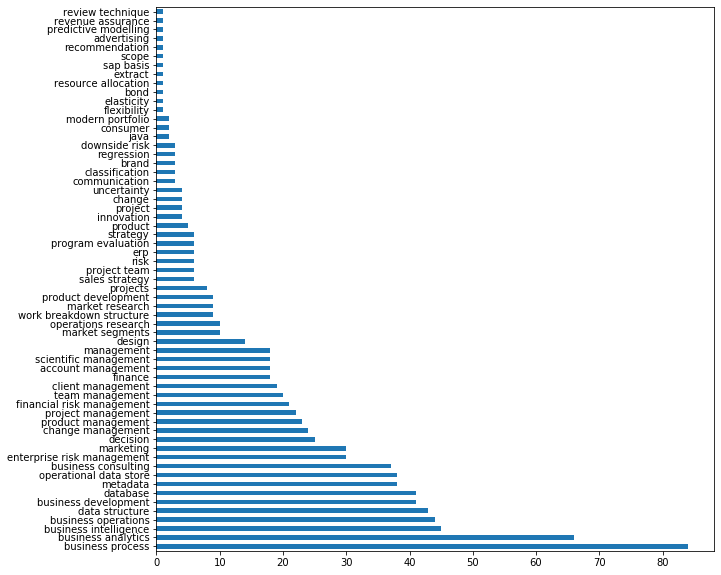

In [53]:
noisy_keys = []
for key_list in ba_data_with_keyword['keywords']:
    noisy_keys += key_list

realKeys = []
for key_list in list(ba_keywords.values()):
    realKeys += key_list

Keys = []
for noisyKey in noisy_keys:
    for realKey in realKeys:
        if noisyKey in realKey:
            Keys.append(realKey)

pd.Series(Keys).value_counts().plot(kind='barh',figsize=(10,10))
plt.show()

##### 14. Fundamentals of Project Management 

This course helps students identify factors that lead to project success, and learn how to plan, analyze, and manage project in practice. Students will gain a strong working knowledge of the basics of project management and be able to immediately use that knowledge to effectively manage projects in their future career. After this course, students will know how to plan a project, save budget on it and how to allocate resources properly. A real project in this course will give students the skills to ensure projects are completed on time and on budget while giving the user the product they expect. 

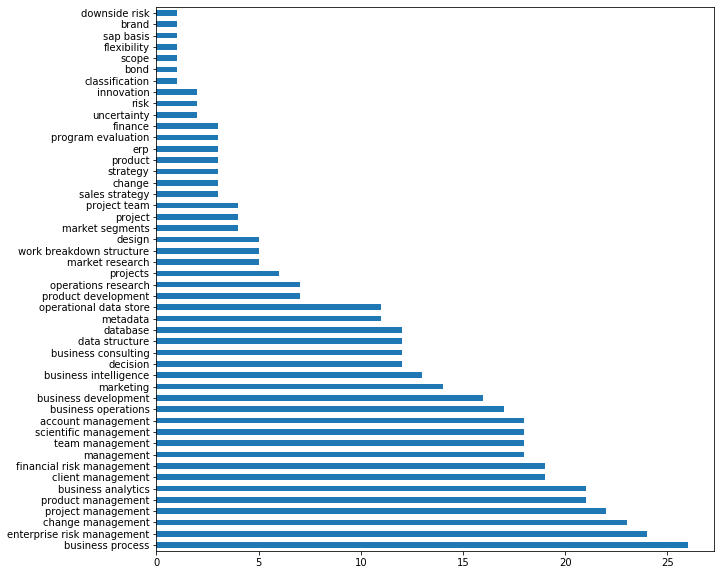

In [54]:
topics = ['project management','project', 'management','development','project development']
keylists = ba_data_with_keyword['keywords'][courseExtract(topics, ba_data_with_keyword)]
L = []
for keylist in keylists:
    L += keylist

real_keys = []
for key_list in list(ba_keywords.values()):
    real_keys += key_list

key = []
for noisyKey in L:
    for realKey in real_keys:
        if noisyKey in realKey:
            key.append(realKey)
pd.Series(key).value_counts().plot(kind='barh',figsize=(10,10))
plt.show()

##### 15. Financial Risk Management

This course combines the knowledge of finance and economics, mathematics, statistics, engineering and computational methods all together. Students will gain an understanding of the theory underlying optimal portfolio construction, the different ways portfolios are actually modelled in reality and how to measure and manage the risk of such portfolios. This course will also introduce students sources of risks in financial environment and ways to measure them such as Value-at-Risk and Expected Shortfall. Assignments as the important evaluations will help students to gain not only technical skills on building and optimizing models in Python but also analytical thinking skills in a financial perspective.

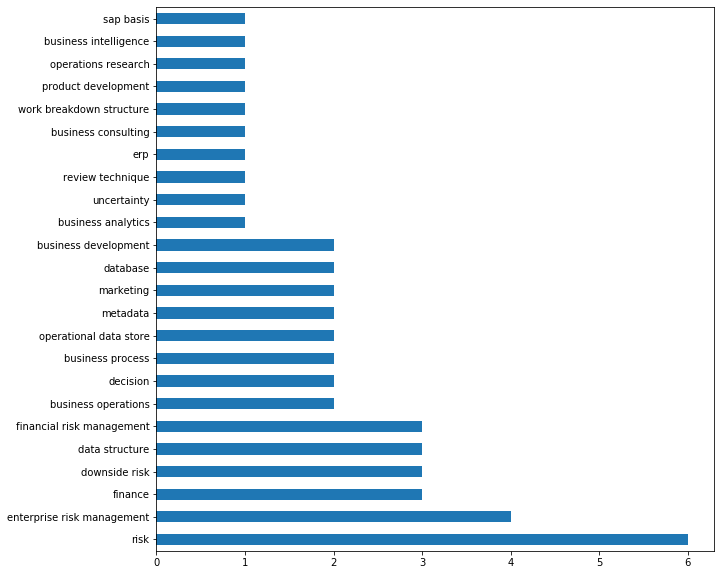

In [55]:
topics = ['risk management','risk']
keylists = ba_data_with_keyword['keywords'][courseExtract(topics, ba_data_with_keyword)]
L = []
for keylist in keylists:
    L += keylist

real_keys = []
for key_list in list(ba_keywords.values()):
    real_keys += key_list

key = []
for noisyKey in L:
    for realKey in real_keys:
        if noisyKey in realKey:
            key.append(realKey)
pd.Series(key).value_counts().plot(kind='barh',figsize=(10,10))
plt.show()

##### 16.  Data Warehousing for Business Intelligence

This course covers data architecture skills. Students will learn the basics of structured data modeling, gain SQL coding experience, know the basics of data warehouse and data manipulation. Students will have the opportunity to work with large datasets in a data warehouse environment to create dashboards and visual analysis by using MicroStrategyonline analytical processing tool and Visual Insights. A final Capstone Project will be the only evaluation and students will apply all skills learnt in this course to build a small, basic data warehouse, analysing and insights, and create dashboards and other visualizations and communicate the data to a group of audience at the end of the semester.

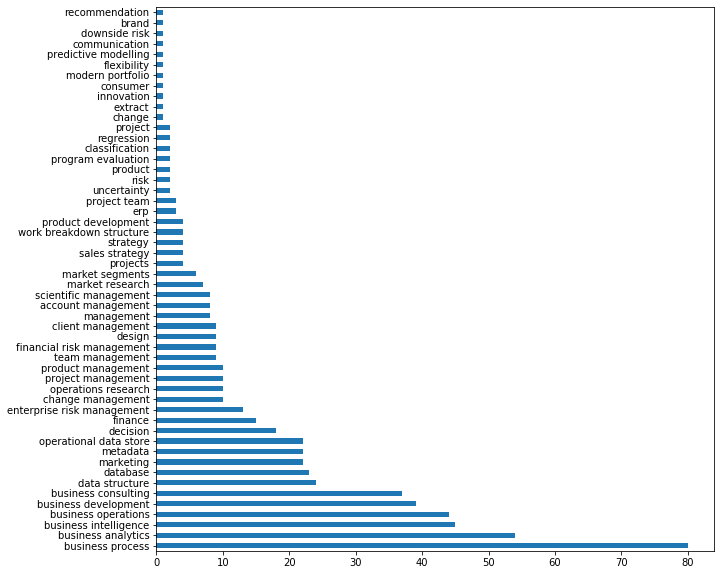

In [56]:
topics = ['business intelligence','business','intelligence']
keylists = ba_data_with_keyword['keywords'][courseExtract(topics, ba_data_with_keyword)]
L = []
for keylist in keylists:
    L += keylist

real_keys = []
for key_list in list(ba_keywords.values()):
    real_keys += key_list

key = []
for noisyKey in L:
    for realKey in real_keys:
        if noisyKey in realKey:
            key.append(realKey)
pd.Series(key).value_counts().plot(kind='barh',figsize=(10,10))
plt.show()

##### 17. Analytics in Marketing

This course will give students ideas that make marketing decisions by combining both marketing principles and data analysis and let them become a data-driven profession that relies on quantitative insights. This course will examine the ways in which marketing has changed and students need to use data answer marketing questions such as the target market segment, the position of product, the most effective way to advertise and the best products to recommend to customers. At the last month of this course,  students will be introduced some advanced machine learning and deep learning methods used in recent marketing strategies such as natural language processing and they will practice the skills on a real-world datasets and give out some good marketing strategies based on what they have learned.

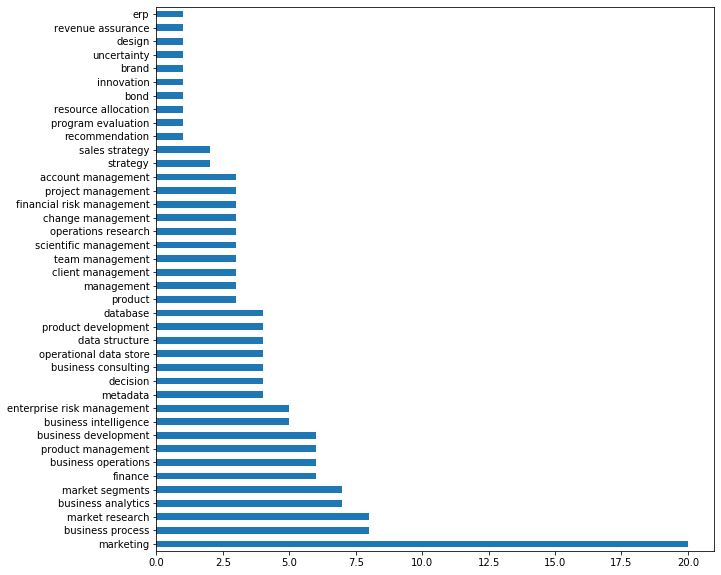

In [57]:
topics = ['marketing modelling','market']
keylists = ba_data_with_keyword['keywords'][courseExtract(topics, ba_data_with_keyword)]
L = []
for keylist in keylists:
    L += keylist

real_keys = []
for key_list in list(ba_keywords.values()):
    real_keys += key_list

key = []
for noisyKey in L:
    for realKey in real_keys:
        if noisyKey in realKey:
            key.append(realKey)
pd.Series(key).value_counts().plot(kind='barh',figsize=(10,10))
plt.show()

##### 18. Managing Change

As the environment of many business becomes increasingly complex and unstable, it is imperative that top managers be able to successfully manage the flexibility in their operations and lives.  Organizations must be able to undertake major change without destructive side effects to be truly successful. Students will learn how to re-imagine change by redefining the change problem and developing the right mindset to influence how change affects the organizations. This course uses real case studies to help students to learn and understand the real strategies or methods used in companies and other organizations.

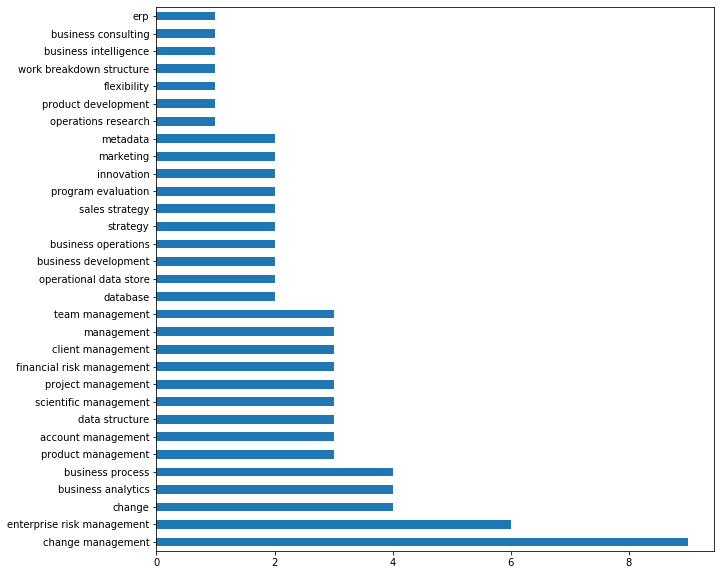

In [58]:
topics = ['change','change management']
keylists = ba_data_with_keyword['keywords'][courseExtract(topics, ba_data_with_keyword)]
L = []
for keylist in keylists:
    L += keylist

real_keys = []
for key_list in list(ba_keywords.values()):
    real_keys += key_list

key = []
for noisyKey in L:
    for realKey in real_keys:
        if noisyKey in realKey:
            key.append(realKey)
pd.Series(key).value_counts().plot(kind='barh',figsize=(10,10))
plt.show()

##### 19. Leadership and Management

This course is designed to let students to get experience in practicing everyday leadership, managing people and organizations effectively through organizational design, and formulate and implement strategy. Students will have opportunity to practice and develop their analytical thinking skills, presentation skills and time, conflict and stress management which are necessary skills in their daily lives or future career. The final project is a strategic leadership and management plan where students are expected to have a real business situation with a partner from companies which will get in their business career earlier before graduating.

##### 20. Prescriptive analytics and Recomendation System

This course using data to discover patterns or buying behaviors in purchasings from customers and building recommendation system for them to improve transactions online and help company make decisions to boost sales. Students will firstly learn how to extract useful data to study customers' buying behaviors and interpret data to make better decisions, them they will learn how to use data about actions in the past to make predictions about actions in the future by predictive models. In the final project, students are expected to implement what they have learned in this class to analyse the pattern in customers and build a predictive model and/or recommendation system to help company to boost sales.

## 2.5 Project & Internship & Extra-Curricular Activities

In the last semester, students must complete a 4-month internship. The internship is aimed for helping students develop real-life data science or artificial intelligence problem solving skills. A Student can either find an industrial-based or research-based internship as long as the responsibilities are closely related with data science or artificial intelligence. During the internship, student must participate in a project and use professional tools (such as SPSS, SAS etc.) to solve problems. A report summarizing the problem-solving procedures should be submitted after the internship. 